# Gaussian_Mixture_Model

We will be implementing the following algorithm:

<img src="assets/gmm_alg.png" width="500">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)
from sklearn.datasets import make_blobs
import time


from plot_util import plot_data, plot_training, confidence_ellipse

# Problem Setup

Say we are trying to model a simple problem where we have 105 points that are 2-d. We know that there are roughly 4 clusters* and we know more-or-less where they start. However, we want to learn the parameters to fit them.

*In the next notebook we do not assume that we have this prior knowledge

In [11]:
unknown_centers = np.asarray([
    [1, -1],  # bottom left
    [7, 5],  # middle
    [8, 7],  # mid-right
    [10, 0]  # bottom right
])


def make_ds(centers):
    points_in_classes = [1500, 250, 200, 40]
    ################################################
    # Initial Guesses
    ################################################
    # Randomly increase/ decrease by 25% each way
    scale = (np.random.randint(low=-80, high=80, size=centers.shape)) / 100

    initial_mu_guesses = centers + (centers * scale)
    return make_blobs(points_in_classes, centers=centers), initial_mu_guesses

(X, y), _ = make_ds(unknown_centers)

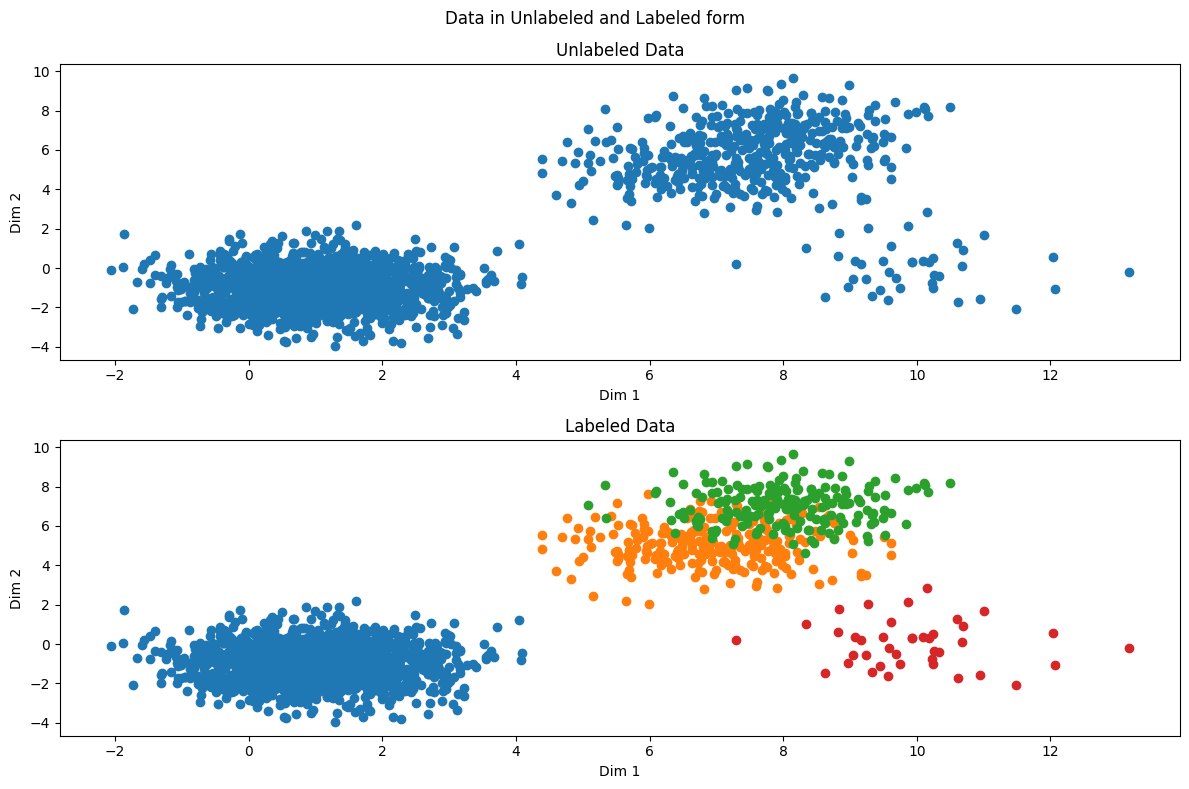

In [12]:
plot_data(X, y, num_centers=len(unknown_centers))

# Diagnostic Functions

The Gaussian Mixture Model is based on the maximum likelihood estimate, which optimizes for the log-likelihood. So, we should probably code it up and ensure that our model is optimizing the log-likelihood correctly.

**Note** this is un-vectorized, but that's fine for our purposes, because we'll leverage jax to speed things up for us. 

**Note** this is step 4 (and 5, really) of the algorithm listed above


![](assets/gaussian_pdf.png)

In [13]:
def gaussian_pdf_cls(x, mus, sigmas, pis) -> list[np.ndarray]:
    # mus, sigmas, and pis must have the same leading axis length
    # To reuse this function later on in the E-step, we save to a list instead of summing the values up directly
    x_lls = []
    data_dim = len(x)
    for cls_idx in range(len(mus)):
        mu, sigma, pi = mus[cls_idx], sigmas[cls_idx], pis[cls_idx]

        lhs = (2 * np.pi ** -data_dim/2) * np.linalg.det(sigma) ** -0.5
        sig_inv = np.linalg.inv(sigma)
        logit_rhs = -0.5 * (x - mu).T @ sig_inv @ (x - mu)
        cls_pdf = (lhs * np.exp(logit_rhs)) * pi

        x_lls.append(cls_pdf)
    return x_lls
        
def log_likelihood(X, mus, sigmas, pis):
    ll = 0
    for i in range(len(X)):
        ll += np.log(np.sum(gaussian_pdf_cls(X[i], mus, sigmas, pis)))
    return ll

# E-step

The "Expectation" step of the Expectation-Maximization algorithm, where we calculate the "expected-ness" of hte data

<img src="assets/e_step.png" width="500">

**Note** the image above was taken (with permission) from [Prof. Matt Golub](https://homes.cs.washington.edu/~mgolub/)'s course, [Machine Learning for Neuroscience (CSE599N)](https://courses.cs.washington.edu/courses/cse599n/24sp/).


In [14]:

def e_step(X, mus, sigmas, pis):
    num_cls = len(mus)
    responsibilities = np.zeros((len(X), num_cls))
    for point_idx in range(len(X)):
        lls = gaussian_pdf_cls(X[point_idx], mus, sigmas, pis)
        denom = np.sum(lls)
        for resp_idx in range(num_cls):            
            responsibilities[point_idx][resp_idx] = lls[resp_idx] / denom
    return responsibilities

# M-step

The "maximixation" step of the Expectation-Maximization algorithm, where we do actual optimization

<img src="assets/m_step.png" width="500">

**Note** the image above was taken (with permission) from [Prof. Matt Golub](https://homes.cs.washington.edu/~mgolub/)'s course, [Machine Learning for Neuroscience (CSE599N)](https://courses.cs.washington.edu/courses/cse599n/24sp/).


In [15]:
def m_step(X, responsibilities, mus, sigmas, pis):
    cls_resp_sum = np.sum(responsibilities, axis=0)
    num_cls = len(mus)

    new_mus = np.zeros_like(mus)
    new_sigmas = np.zeros_like(sigmas)
    new_pis = np.zeros_like(pis)

    for cls_idx in range(num_cls):
        cls_resp = np.expand_dims(responsibilities[:, cls_idx], axis=-1)
        scale_factor = 1 / cls_resp_sum[cls_idx]
        new_mus[cls_idx] = scale_factor * np.sum(cls_resp * X, axis=0)

        deviation = X - mus[cls_idx]
        scaled_deviation = cls_resp * deviation
        new_sigmas[cls_idx] = scale_factor * (scaled_deviation.T @ deviation)
        new_pis[cls_idx] = cls_resp_sum[cls_idx] / len(X)
        
    return new_mus, new_sigmas, new_pis

# Initialize the Guesses 

- Step 1 of the original algorithm

In [16]:
def initialize_guesses(X, guessed_num_classes):
    # We just say the covariance of the entire dataset is the covariance of each sub-cluster.
    sigmas = np.asarray([np.cov(X.T) for _ in range(guessed_num_classes)])
    
    # We simply 
    cls_probs = np.expand_dims(
        np.asarray([1 / guessed_num_classes for _ in range(guessed_num_classes)]).T,
        axis=-1
    )

    _, mus = make_ds(unknown_centers)

    return mus, sigmas, cls_probs
    


# Putting it all together

Assemble the final algorithm

In [17]:
def gmm(
    X: np.ndarray,
    guess_num_classes,
    verbose=False
):

    mus, sigmas, cls_probs = initialize_guesses(X, guess_num_classes)
    counter = 0
    ll_container = []
    TOL = 0.00001
    ll_container.append(np.inf)

    start_time = time.perf_counter()
    while True:  # Run until converges
        # e-step
        responsibilities = e_step(X, mus, sigmas, cls_probs)

        # m-step
        mus, sigmas, cls_probs = m_step(X, responsibilities, mus, sigmas, cls_probs)
        # Recalculate the log-likelihood
        ll_curr = float(log_likelihood(X, mus, sigmas, cls_probs))

        if np.abs(ll_container[-1] - ll_curr) < TOL:
            print(f"Converged to within {TOL} after: {counter} iterations")
            break

        ll_container.append(float(ll_curr))
        if verbose and counter % 2 == 0 and counter > 0:
            print(f"Data Log-Likelihood at iteration: {counter} = {ll_curr:.6f}")
        counter += 1

    responsibilities = e_step(X, mus, sigmas, cls_probs)
    print(f"Total Training time was: {time.perf_counter() - start_time}s")
    return mus, sigmas, cls_probs.T, responsibilities.T, ll_container[1:]
    # -------------------------- #



In [18]:
GUESS_NUM_CLASSES = 4
mus, sigmas, cls_priors, _, lls = gmm(
    X,
    guess_num_classes=GUESS_NUM_CLASSES,
    verbose=True
)

/var/folders/nr/plbmjfs57_98f06_km7x4ny40000gn/T/ipykernel_44546/1235736518.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  responsibilities[point_idx][resp_idx] = lls[resp_idx] / denom


Data Log-Likelihood at iteration: 2 = -9326.782472
Data Log-Likelihood at iteration: 4 = -8706.425847
Data Log-Likelihood at iteration: 6 = -7923.323785
Data Log-Likelihood at iteration: 8 = -7920.554012
Data Log-Likelihood at iteration: 10 = -7919.760200
Data Log-Likelihood at iteration: 12 = -7919.207348
Data Log-Likelihood at iteration: 14 = -7918.619564
Data Log-Likelihood at iteration: 16 = -7917.928573
Data Log-Likelihood at iteration: 18 = -7917.133297
Data Log-Likelihood at iteration: 20 = -7916.285839
Data Log-Likelihood at iteration: 22 = -7915.483136
Data Log-Likelihood at iteration: 24 = -7914.827005
Data Log-Likelihood at iteration: 26 = -7914.367319
Data Log-Likelihood at iteration: 28 = -7914.083020
Data Log-Likelihood at iteration: 30 = -7913.916271
Data Log-Likelihood at iteration: 32 = -7913.813936
Data Log-Likelihood at iteration: 34 = -7913.743054
Data Log-Likelihood at iteration: 36 = -7913.687202
Data Log-Likelihood at iteration: 38 = -7913.639111
Data Log-Likelih

# Visualize Training Process

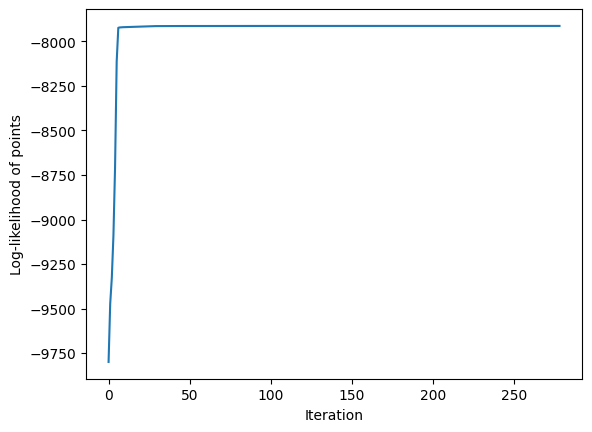

In [19]:
plot_training(lls)

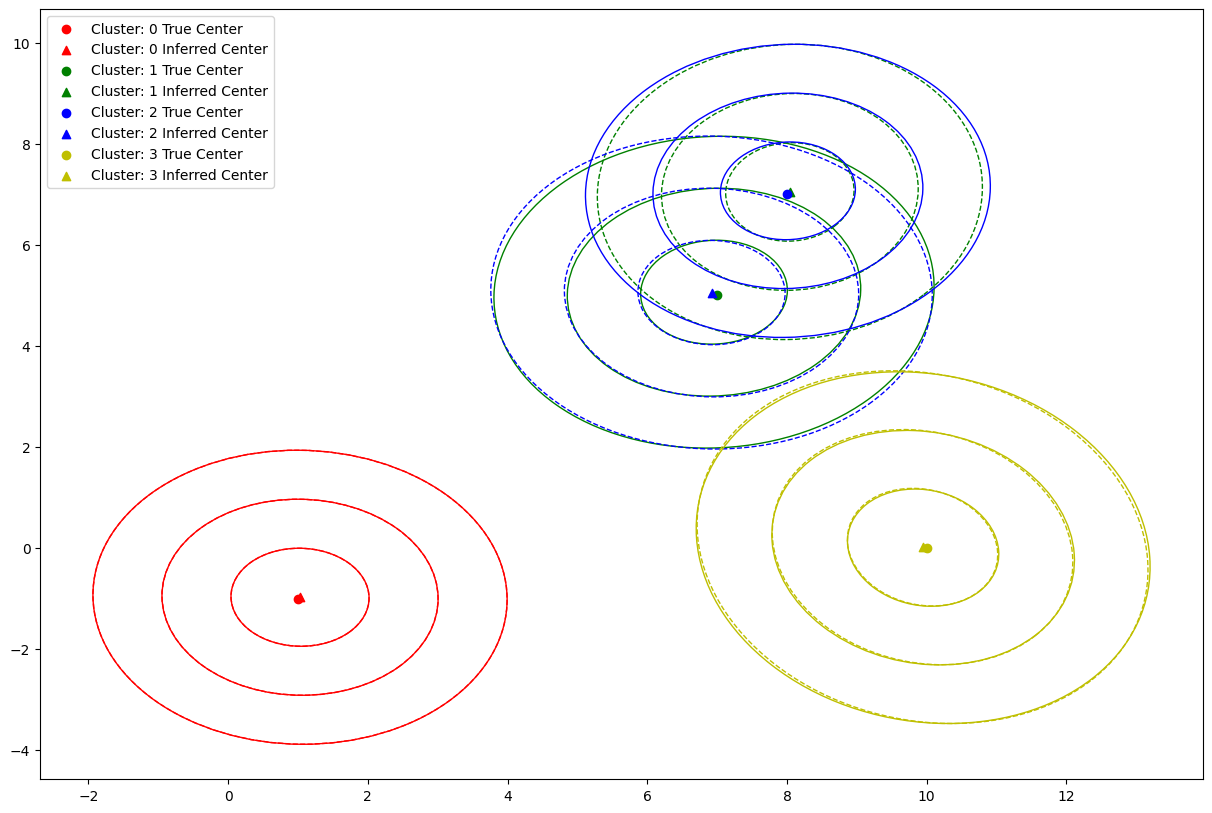

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))

colors = ["r", "g", "b", "y"]

for i, c in enumerate(colors):
    
    # Plot the centers
    plt.scatter(unknown_centers[i, 0], unknown_centers[i, 1], c=c, marker="o", label=f"Cluster: {i} True Center")
    plt.scatter(mus[i, 0], mus[i, 1], c=c, marker="^", label=f"Cluster: {i} Inferred Center")
    
    # Plot the standard deviations
    mask = y == i
    masked_points = X[mask]
    mu_x = np.mean(masked_points, axis=0)
    sigma = np.cov(masked_points[:, 0], masked_points[:, 1])
    confidence_ellipse(mu_x, sigma,  ax=axs, n_std=1, edgecolor=c, linestyle="-")
    confidence_ellipse(mu_x, sigma, ax=axs, n_std=2, edgecolor=c, linestyle="-")
    confidence_ellipse(mu_x, sigma, ax=axs, n_std=3, edgecolor=c, linestyle="-")


    confidence_ellipse(mus[i], sigmas[i],  ax=axs, n_std=1, edgecolor=c, linestyle="--")
    confidence_ellipse(mus[i], sigmas[i], ax=axs, n_std=2, edgecolor=c, linestyle="--")
    confidence_ellipse(mus[i], sigmas[i], ax=axs, n_std=3, edgecolor=c, linestyle="--")
plt.legend(loc="best")
